# Seattle Bike counts 

## initial cleaning ups

Several highlights here. parse_dates can be used to parse dates based on the info of a particular column. Index_col can be used to build a index column. We end up with integer index if that is not specified.

The next thing we do is to add a column called total based on daily summation. And there's two major ways to do it: 1. get the two columns and sum them up. 2. Use query like syntax

In [1]:
import pandas as pd 
#parse_dates specify which columns to read date from
bike_data = pd.read_csv('bikes.csv', parse_dates=['Date'], index_col='Date')
bike_data.columns = ['east', 'west']

In [2]:
bike_data.head()
#get the totoal
bike_data_copy = bike_data.copy()
bike_data_copy.eval('total=east+west', inplace=True)
bike_data_copy.head()

,east,west,total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


In [3]:
bike_data['total'] = bike_data['east'] + bike_data['west']
bike_data.dropna(inplace=True)
bike_data.describe()

,east,west,total
count,54735.000000,54735.000000,54735.000000
mean,52.619530,58.300850,110.920380
std,68.034365,84.733147,140.018123
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,29.000000,60.000000
75%,70.000000,70.000000,144.000000
max,698.000000,717.000000,957.000000


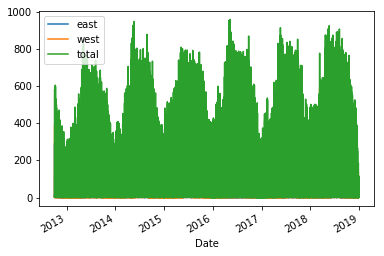

In [4]:
%matplotlib inline
bike_data.plot() #for each column generate a line...not so informative here

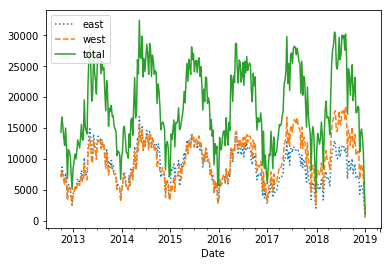

In [5]:
weekly_sum = bike_data_copy.resample('W').sum() # time stamp has to be (part) in index.
weekly_sum.plot(style=[':', '--','-']) #sum of each week... 

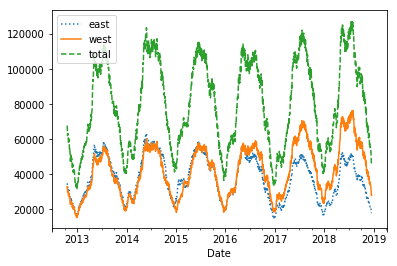

In [6]:
daily_data = bike_data.resample('D').sum()
daily_data.rolling(30, center=True).sum().plot(style=[':', '-', '--']) #center means 15 days on each side

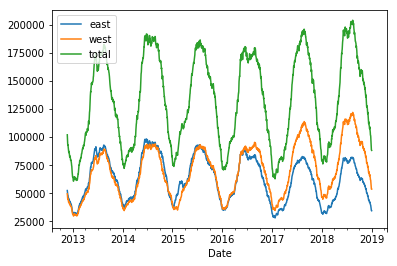

In [7]:
#similarly we can use gaussian kernel to smooth it
#bigger std is going to make graphs smoother
daily_data.rolling(50, win_type='gaussian').sum(std=100).plot()

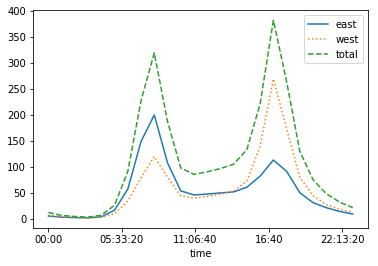

In [8]:
#groupy time of the day... 
#for pd.to_datetime.. the series will have a date and time attribute!
by_hour = bike_data.groupby(bike_data.index.time).mean()
by_hour.plot(style=['-',':','--'])

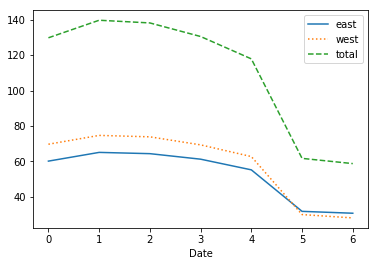

In [9]:
#similarly we can groupby week and days..
bike_data.groupby(bike_data.index.dayofweek).mean().plot(style=['-',':','--'])

In [10]:
import numpy as np 
weekdays = bike_data.loc[bike_data.index.dayofweek < 5]
weekend = bike_data.loc[bike_data.index.dayofweek >= 5 ]

Text(0.5, 1.0, 'weekend')

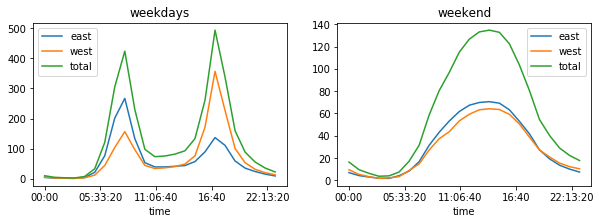

In [11]:
import matplotlib.pyplot as plt 
f, axes = plt.subplots(1,2, figsize=[10,3])

weekdays.groupby(weekdays.index.time).mean().plot(ax=axes[0])
axes[0].set_title('weekdays')
weekend.groupby(weekend.index.time).mean().plot(ax=axes[1])
axes[1].set_title('weekend')

resample is a data aggregation operation and asfreq is a data selection which keeps the last value by default. Here's a comparison with the bike data

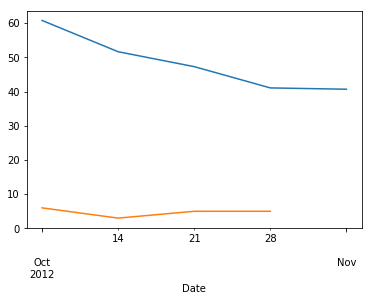

In [12]:
east_ts = bike_data.east
one_month = east_ts['2012-10-03':'2012-11-03']
f, ax = plt.subplots(1,1)
one_month.resample('w').mean().plot(ax=ax)
one_month.asfreq(freq='W').plot(ax=ax)

This above graph looks bizzar because the asfreq function takes the last value of a period, which is an hourly count. But the resample('w').mean() gives the mean value of that week. Note that the last hour of a day has to be around midnight and that explains the low number.

In [13]:
weather = pd.read_csv('weather.csv')
weather['DATE'] = pd.to_datetime(weather.DATE, format='%Y%m%d')
weather = weather[(weather.DATE >= '2012-01-01') & (weather.DATE <= '2014-12-31')]
weather['dry'] = (weather.PRCP>0).astype(int)
weather['TMIN'] = weather['TMIN']/10
weather['TMAX'] = weather['TMAX']/10
weather['temp'] = 0.5*(weather['TMIN'] + weather['TMAX'] )
weather = weather[['temp', 'DATE', 'dry', 'PRCP']]

daily_total = bike_data.resample('D').sum()['total']
daily_total = daily_total.loc['2012':'2014']

X = pd.get_dummies(daily_total.index.dayofweek)
X.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
X.index = daily_total.index

In [14]:
from pandas.tseries.holiday import USFederalHolidayCalendar #generate a list of holidays
holiday_indicator = pd.Series(1, index=USFederalHolidayCalendar().holidays('2012', '2014'))
holiday_indicator = holiday_indicator.to_frame()
holiday_indicator.columns = ['holiday']

X = pd.merge(X, holiday_indicator, left_index=True, right_index=True, how='left')
X.loc[X.holiday.isnull(), 'holiday'] = 0

In [15]:
def hours_of_daylight(date, axis=23.44, latitude=47.61): 
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))* np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25))) 
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
X['daylight_hrs'] = list(map(hours_of_daylight, X.index))            

In [16]:
X_combined = pd.merge(X, weather, left_index=True, right_on='DATE', how='left')
X_combined.reset_index(drop=True)
X_combined = X_combined.set_index(['DATE'])
X_combined['annual'] = (X_combined.index - X_combined.index[0]).days/365
X_combined.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,temp,dry,PRCP,annual
DATE,,,,,,,,,,,,,
2012-10-03,0,0,1,0,0,0,0,0.0,11.277359,13.35,0,0,0.000000
2012-10-04,0,0,0,1,0,0,0,0.0,11.219142,13.60,0,0,0.002740
2012-10-05,0,0,0,0,1,0,0,0.0,11.161038,15.30,0,0,0.005479
2012-10-06,0,0,0,0,0,1,0,0.0,11.103056,15.85,0,0,0.008219
2012-10-07,0,0,0,0,0,0,1,0.0,11.045208,15.85,0,0,0.010959


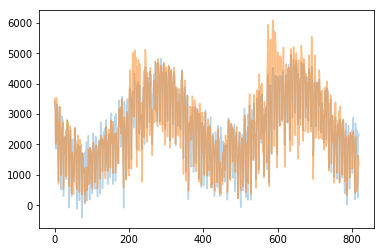

In [17]:
from sklearn.linear_model import LinearRegression
m = LinearRegression(fit_intercept=False)
m.fit(X_combined, daily_total.values)
plt.plot(m.predict(X_combined), alpha=0.3)
plt.plot(daily_total.values, alpha=0.5)

In [18]:
from sklearn.utils import resample
m = LinearRegression(fit_intercept=False)
result_recorder = []
for i in range(1000):
    v = m.fit(*resample(X_combined, daily_total.values)).coef_
    result_recorder.append(v)

In [19]:
fitted_values = pd.DataFrame(result_recorder)
fitted_values.columns = X_combined.columns
upper_bound = fitted_values.apply(np.quantile, q=0.975, axis=0) #arguments can be passed in like keywords!
lower_bound = fitted_values.apply(np.quantile, q=0.025, axis=0)
err = fitted_values.apply(np.std, axis=0)
pnt_estimates = fitted_values.apply(np.std, axis=0) 

In [20]:
pd.DataFrame({'point_estimate':pnt_estimates, 
              'standard dev': err, 
              'upper 95': upper_bound, 
              'lower 5':lower_bound})

,point_estimate,standard dev,upper 95,lower 5
Mon,106.632844,106.632844,1021.530486,599.787978
Tue,104.467563,104.467563,1152.304497,745.635788
Wed,103.248966,103.248966,1142.536716,750.206379
Thu,112.301515,112.301515,1012.005749,574.491200
Fri,100.549785,100.549785,697.873861,307.272832
Sat,101.736610,101.736610,-523.016636,-917.946353
Sun,103.960184,103.960184,-548.407076,-954.903071
holiday,229.639619,229.639619,-708.182302,-1588.048067
daylight_hrs,10.412385,10.412385,158.789205,117.954098
temp,3.917849,3.917849,75.195121,59.906063


Resample is a function that literally  does, resample.. not to be confused to with resample method of dataframe. That one is used to handle time series. This one, however, can be used to give non-param bootstrap.

In [21]:
print(resample(X_combined, daily_total.values)[0].shape)
print(resample(X_combined, daily_total.values)[1].shape)

(820, 13)
(820,)
